In [59]:
import csv 
import random 
import networkx as nx
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from gprofiler import GProfiler
import pandas as pd
import requests
%matplotlib inline 
font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 32}



plt.rc('font', **font) 

G0 = nx.read_weighted_edgelist("4932.protein.links.v12.0.txt",comments="#",nodetype=str) #Delete the header first or this might not work!
G0 

In [60]:
threshold_score = 500
for edge in G0.edges: 
    weight = list(G0.get_edge_data(edge[0],edge[1]).values())
    if(weight[0] <= threshold_score):
        G0.remove_edge(edge[0],edge[1])

print("( O v O)b") 

( O v O)b


In [61]:
print(G0.number_of_nodes())
largest_cc = max(nx.connected_components(G0) , key=len) 
Gc = G0.subgraph(largest_cc) 
print(Gc.number_of_nodes()) 

6538
6159


In [62]:
commus = nx.community.label_propagation_communities(Gc) 
print("commu # :" , len(commus))
modularity_v1 = nx.community.modularity(Gc , commus) 

print("modularity :" , modularity_v1) 


G = nx.Graph(Gc) 
for i in commus : 
    if len(i) < 2 : 
        for ii in i : 
            G.remove_node(ii) 
print("////////// REMOVAL ///////////") 
print("\t|G0| :" , G0.number_of_nodes()) 
print("\t|Gc| :" , Gc.number_of_nodes()) 
print("\t|G| :" , G.number_of_nodes()) 

newer_commus = nx.community.label_propagation_communities(G) 
modularity_v2 = nx.community.modularity(G , newer_commus) 

print("new modularity :" , modularity_v2) 

commu # : 44
modularity : 0.4414026109493013
////////// REMOVAL ///////////
	|G0| : 6538
	|Gc| : 6159
	|G| : 6159
new modularity : 0.4414026109493013


In [63]:
def run_many_times(n=101 , G=G) : 
    run_records = [] 
    for i in range(n) : 
        random_number_in_range = random.randint(0 , 2**(64)-1) 
        rv = nx.community.fast_label_propagation_communities(G , seed=random_number_in_range) 
        rv_list = [] 
        
        
        for ii in rv : 
            rv_list.append(ii) 
        #for i in rv_list : 
        #    print(i) 
        
        run_records.append([rv_list , random_number_in_range]) 
        
        print("                    " , end='\r') 
        print("( O v O) {" , i+1 , ")" , end='\r') 

    
    return run_records 

In [64]:
def cal_rela_counters(runs , G=G) : 
    rela_c = {} 
    for i in G : 
        #rela_c.append( [i , [0]*len(G)] ) 
        rela_c[i] = [0]*len(G) 

    """   
    for i in runs : 
        for ii in G : 
            for iii in range(len(i[0])) : #result_i 
                if ii in i[0][iii] : 
                    for iiii in i[0][iii] : 
                        if ii == iiii : 
                            continue 
                        #rela_c[ii][1][iiii] += 1 
                        rela_c[ii][0] += 1 
    """
    return rela_c 

In [65]:
def top_few_btween_member(Gin , lookfor = "" , show=0) : 
    if len(Gin) < 5 : 
        #2/0 
        tmp_l = [i for i in Gin] 
        return tmp_l 
        
    tmp_btweenCentra = nx.betweenness_centrality(Gin) 
    tmp_L2 = [] 
    tmp_L1 = [] 
    pack = [] 
    for i in Gin : 
        tmp_L1.append(tmp_btweenCentra[i]) 
        tmp_L2.append(i) 

    tmp_L1, tmp_L2 = zip(*sorted(zip(tmp_L1, tmp_L2)))   ### Thanks to https://stackoverflow.com/questions/9764298/given-parallel-lists-how-can-i-sort-one-while-permuting-rearranging-the-other 

    
    for i in range(5) : 
        if show : 
            print("[ " + tmp_L2[-(1+i)] , "|" + str(tmp_L1[-(1+i)]) + "]") 
        pack.append(tmp_L2[-(1+i)]) 
    if len(lookfor) > 0 : 
        if lookfor in tmp_L2 : 
            for i in tmp_L2 : 
                if i == lookfor : 
                    print("#" + str(len(tmp_L2) - tmp_L2.index(lookfor)) , "\t" , lookfor) 
        else : 
            print("( O _ O) { ??? )") 
    return pack  

In [66]:
def tmp_F(runs , in_G=G) :  
    rela_c = {} 
    for i in in_G : 
        rela_c[i] = {} 
        for ii in in_G : 
            rela_c[i][ii] = 0 

    tmp_c = 0 
    for iiii in runs : 
        for i in in_G : 
            for ii in iiii[0] : 
                if i in ii : 
                    for iii in ii : 
                        if i == iii : 
                            continue 
                        rela_c[i][iii] += 1 
        tmp_c += 1 
        print(str(tmp_c) + "/" + str(len(runs)) + " RUN\t[ OK ]" , end='\r') 

    return rela_c 

In [67]:
def dense_commu_of(tar_node , rela_counter_in , run_result) : 
    dense_commu = [] 
    drifters = [] 
    for i in rela_counter_in[tar_node] : 
        if rela_counter_in[tar_node][i]/len(run_result) >= 0.95 :        #overlap 95% of times 
            dense_commu.append(i) 
        elif rela_counter_in[tar_node][i]/len(run_result) >= 0.5 : 
            if i != tar_node : 
                drifters.append(i) 
            
    return [dense_commu , drifters] 

In [68]:
def QC_Idea_v1(relas , runs) : 
    
    self_def_commus = [] 
    
    all_nodes = [] 
    all_nodes_info = {} 
    for i in relas : 
        all_nodes.append( i ) 
        all_nodes_info[i] = [0 , -1 , []]    # [?dense , dense # , belong] 
#    print(len(relas) , len(all_nodes) , len(all_nodes_info)) 


    new_commu_id_counter = 0 
    for i in relas : 
        cur_tar = i 
        if all_nodes_info[cur_tar][0] == 1 :      # already dense 
            continue 
        else : 
            tmp = dense_commu_of(cur_tar , relas , runs) 
            raw_dense_list = tmp[0] 
            raw_drifter_list = tmp[1] 
            new_commu_pack = [cur_tar] 
            for i in raw_dense_list : 
                if 0 == all_nodes_info[i][0] : 
                    new_commu_pack.append(i) 
            for i in new_commu_pack : 
                all_nodes_info[i][0] = 1 
                all_nodes_info[i][1] = new_commu_id_counter 
                all_nodes_info[i][2].append(new_commu_id_counter) 
            for i in raw_drifter_list : 
                all_nodes_info[i][2].append(new_commu_id_counter) 

            self_def_commus.append(new_commu_pack) 

            #print(len(raw_drifter_list) , len(raw_drifter_list) + len(new_commu_pack)) 


        new_commu_id_counter += 1 
        #print("( O A O) { STOP )") 
        #break 
    print(new_commu_id_counter) 
    return [self_def_commus , all_nodes_info] 


In [69]:
#rela_counter IN 
#run_result IN 

def QC_Idea_v2(relas , runs , starting_node="4932.YMR190C") : 
    
    self_def_commus = [] 
    
    all_nodes = [] 
    all_nodes_info = {} 
    for i in relas : 
        all_nodes.append( i ) 
        all_nodes_info[i] = [0 , -1 , []]    # [?dense , dense # , belong] 
    #print(">>" , len(all_nodes_info)) 

    new_commu_id_counter = 0 

    if len(starting_node) > 0 : 
        cur_tar = starting_node 
    

        raw_dense_list , raw_drifter_list = dense_commu_of(cur_tar , relas , runs) 

        new_commu_pack = [cur_tar] 
        for ii in raw_dense_list : 
            #if 0 == all_nodes_info[ii][0] : 
            new_commu_pack.append(ii) 
        for ii in new_commu_pack : 
            all_nodes_info[ii][0] = 1 
            all_nodes_info[ii][1] = new_commu_id_counter 
            all_nodes_info[ii][2].append(new_commu_id_counter) 
        for ii in raw_drifter_list : 
            all_nodes_info[ii][2].append(new_commu_id_counter) 
    
        self_def_commus.append(new_commu_pack) 
    
    
        new_commu_id_counter = 1 


    for i in relas : 
        cur_tar = i 
        if all_nodes_info[cur_tar][0] == 1 :      # already dense 
            continue 
#        elif len(all_nodes_info[cur_tar][2]) > 0 :    # drifter 
#            continue 
        else : 
            tmp = dense_commu_of(cur_tar , relas , runs) 
            raw_dense_list = tmp[0] 
            raw_drifter_list = tmp[1] 
            new_commu_pack = [cur_tar] 

            if len(raw_dense_list) < 11 : 
                continue 
            
            for ii in raw_dense_list : 
                if 0 == all_nodes_info[ii][0] : 
                    new_commu_pack.append(ii) 
                    
            if len(new_commu_pack) > 10 : 
                self_def_commus.append(new_commu_pack) 
            else : 
                continue 
                
            for ii in new_commu_pack : 
                all_nodes_info[ii][0] = 1 
                all_nodes_info[ii][1] = new_commu_id_counter 
                all_nodes_info[ii][2].append(new_commu_id_counter) 
            for ii in raw_drifter_list : 
                all_nodes_info[ii][2].append(new_commu_id_counter) 

#            if len(new_commu_pack) > 10 : 
#                self_def_commus.append(new_commu_pack) 
#            else : 
#                continue 

            #print(len(raw_drifter_list) , len(raw_drifter_list) + len(new_commu_pack)) 

        #print(new_commu_id_counter) 
        new_commu_id_counter += 1 

            
        
    return [self_def_commus , all_nodes_info] 


In [70]:
#def possi_dests(ni , dense_commus=tmp_box , nodes_info=tmp_pox) : 
#              starting node  ,  self_def_commus  ,  all_nodes_info 
def possi_dests(ni , dense_commus , nodes_info) : 

    trig = 0 
    
    ni_idx = 0 
    for i in dense_commus : 
        if ni in i : 
            print("[" + str(ni) + "]" , "@" , ni_idx)
            break 
        ni_idx += 1 


    possi_padding = [] 
    possi_dest = [] 
    feelted_possi_dest = [] 
    feelted_possi_padding = [] 

    
    for i in nodes_info : 
        if (ni_idx in nodes_info[i][2]) and nodes_info[i][0] == 0 :    #nodes_info[i][0] == 0 and 
            # collect drifters 
            possi_padding.append(i) 
            for ii in nodes_info[i][2] : 
                if ii not in possi_dest and ii != ni_idx : 
                    possi_dest.append(ii) 
    #print(len(possi_padding) , possi_dest) 
    #print(len(dense_commus)) 
    #print("~~~~~~~~~~~~") 
    for i in possi_dest : ########## 
        
        if len(dense_commus[i]) >= 2 : 
            feelted_possi_dest.append(i) 
    if 0 == len(feelted_possi_dest) : 
        print("( ' ^ ') { EMPTY )") 
        trig = 1 

    #print(feelted_possi_dest) 
    #print("paddings :" , str(len(possi_padding)) + "<>" + str(len(tmp_box[ni_idx])) , ": dense") 
    if trig : 
        return [possi_dest , possi_padding] 
    return [feelted_possi_dest , possi_padding] 
            

In [71]:
tar_node = "4932.YMR190C" 

In [72]:
run_result = run_many_times(101 , G) 
rela_counter = tmp_F(run_result , G) 

In [73]:
#tmp = QC_Idea_v2(rela_counter , run_result , "4932.YMR190C") 
tmp = QC_Idea_v2(rela_counter , run_result , tar_node) 
self_def_commus = tmp[0]    #self def commus 
all_node_info = tmp[1]     # info 


tar_idx = 0 
for i in self_def_commus : 
    if tar_node in i : 
        print("[" + tar_node + "]" , "@" , tar_idx) 
        break 
    tar_idx += 1 





[4932.YMR190C] @ 0


In [74]:
print(len(self_def_commus)) 
tmp_l = [] 
for i in all_node_info :
    for ii in all_node_info[i][2] : 
        tmp_l.append(ii) 
print(max(tmp_l)) 

49
48


In [75]:
feelted_self_def_commus = [] 
for i in self_def_commus : 
    if len(i) > 7 : 
        feelted_self_def_commus.append(i) 

print(" |pre feelter| =" , len(self_def_commus)) 
print("|post feelter| =" , len(feelted_self_def_commus)) 


 |pre feelter| = 49
|post feelter| = 49


In [76]:
other_sides , paddings = possi_dests(tar_node , self_def_commus , all_node_info) 

print(other_sides) 
print(len(paddings)) 

[4932.YMR190C] @ 0
[1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 29, 32, 33, 34, 35, 36, 37, 38, 39, 40, 42, 43, 44, 45, 46, 47, 48, 31, 41]
426


In [77]:
""" 
tmp_c = 0 
for i in all_node_info : 
    print(all_node_info[i]) 
    tmp_c += 1 
    if tmp_c > 101 : 
        break 
""" 

' \ntmp_c = 0 \nfor i in all_node_info : \n    print(all_node_info[i]) \n    tmp_c += 1 \n    if tmp_c > 101 : \n        break \n'

In [78]:
tmp_c = 0 
tmp_import_list = ["YMR190C", "YNL088W", "YLR234W", "YPL024W", "YMR167W"] 
for ii in tmp_import_list : 
    for i in self_def_commus : 
        if "4932." + ii in i : 
            print("@" , tmp_c)

@ 0
@ 0
@ 0
@ 0
@ 0


In [79]:

print() 
for i in other_sides : 
    tmp_pack = [] 
    dd_list = [] 
    tmp_G = G.subgraph(self_def_commus[i]) 
    

    for ii in paddings : 
        if i in all_node_info[ii][2] : 
            tmp_pack.append(ii) 
    tmp_top_btw = top_few_btween_member(tmp_G , "" , 0) 
    print("   starting point" , ":\t" , tar_node) 
    #print("\tdrifters :\t" , tmp_pack) 
    print("essens 0f commu_" + str(i) + " :\t" , tmp_top_btw) 

    for ii in self_def_commus[tar_idx] : 
        dd_list.append(ii) 
    for ii in self_def_commus[i] : 
        dd_list.append(ii) 
    for ii in tmp_pack : 
        dd_list.append(ii) 
    dd_G = G.subgraph(dd_list) 

    for i in range(len(tmp_top_btw)) : 
        try : 
            print(">>>LinkingPath " + str(i+1) + " : HEAD --> TAIL\n\t\t" , nx.shortest_path(dd_G , tar_node , tmp_top_btw[i]) ) 
            #break 
        except nx.NetworkXNoPath : 
            print("can't reach" , "[" + tmp_top_btw[i] + "]") 
            if i == len(tmp_top_btw) - 1 : 
                print("[ NO PATH ]") 
            #print("/////////////////////////////////////////\n////////////// NO PATH /////////////////\n///////////////////////////////////") 
            
        
    #print(">>>LinkingPath : HEAD --> Drifter\n\t\t" , nx.shortest_path(G , "4932.YMR190C" , "4932.YDR545W") ) 
        
    print("\n\n") 




   starting point :	 4932.YMR190C
essens 0f commu_1 :	 ['4932.YGL026C', '4932.YER069W', '4932.YPR035W', '4932.YKL211C', '4932.YBR208C']
>>>LinkingPath 1 : HEAD --> TAIL
		 ['4932.YMR190C', '4932.YER041W', '4932.YGL026C']
>>>LinkingPath 2 : HEAD --> TAIL
		 ['4932.YMR190C', '4932.YBR114W', '4932.YER069W']
>>>LinkingPath 3 : HEAD --> TAIL
		 ['4932.YMR190C', '4932.YOR202W', '4932.YPR035W']
>>>LinkingPath 4 : HEAD --> TAIL
		 ['4932.YMR190C', '4932.YBR114W', '4932.YKL211C']
>>>LinkingPath 5 : HEAD --> TAIL
		 ['4932.YMR190C', '4932.YJL092W', '4932.YBR208C']



   starting point :	 4932.YMR190C
essens 0f commu_2 :	 ['4932.YLL013C', '4932.YLR378C', '4932.YFR004W', '4932.YLL039C', '4932.YNL178W']
>>>LinkingPath 1 : HEAD --> TAIL
		 ['4932.YMR190C', '4932.YGL058W', '4932.YLL013C']
>>>LinkingPath 2 : HEAD --> TAIL
		 ['4932.YMR190C', '4932.Q0160', '4932.YLR378C']
>>>LinkingPath 3 : HEAD --> TAIL
		 ['4932.YMR190C', '4932.YGL058W', '4932.YFR004W']
>>>LinkingPath 4 : HEAD --> TAIL
		 ['4932.YMR

In [121]:
def unique_intersecting_proteins(df, target_protein):

    if df.empty:
        return []

    if 'intersections' not in df.columns:
        raise KeyError("'intersections vanished")
    
    filtered_df = df[df['intersections'].apply(lambda x: isinstance(x, list) and len(x) > 1 and target_protein in x)]

    unique_proteins = set()
    for intersections in filtered_df['intersections']:
        if isinstance(intersections, list):
            unique_proteins.update(intersections)
    
    unique_proteins.discard(target_protein)
    return list(unique_proteins)

In [111]:
comm_func_similar = {}
print() 
for community_idx in other_sides : 
    gp = GProfiler(return_dataframe=True)
    tmp_pack = [] 
    dd_list = [] 
    tmp_G = G.subgraph(self_def_commus[community_idx]) 
    

    for ii in paddings : 
        if community_idx in all_node_info[ii][2] : 
            tmp_pack.append(ii) 
    tmp_top_btw = top_few_btween_member(tmp_G , "" , 0) 

    essen_len = len(tmp_top_btw)

    print("   starting point" , ":\t" , "4932.YMR190C") 
    #print("\tdrifters :\t" , tmp_pack) 
    print("essens 0f commu_" + str(community_idx) + " :\t" , tmp_top_btw) 

    for ii in self_def_commus[tar_idx] : 
        dd_list.append(ii) 
    for ii in self_def_commus[community_idx] : 
        dd_list.append(ii) 
    for ii in tmp_pack : 
        dd_list.append(ii) 
    dd_G = G.subgraph(dd_list)

    functionality = 0

    for essen_prot_idx in range(len(tmp_top_btw)) : 
        try : 
            shortest_path_list = nx.shortest_path(dd_G , "4932.YMR190C" , tmp_top_btw[essen_prot_idx])
            df = gp.profile( organism="scerevisiae", query=shortest_path_list, no_evidences=False)
            unique_proteins = unique_intersecting_proteins(df, "4932.YMR190C")
            functionality = functionality + len(unique_proteins)/(len(shortest_path_list)-1)
            if len(unique_proteins) > 0:
                print(">>>LinkingPath: " + str(i+1) + " : HEAD --> TAIL\n\t\t" , shortest_path_list, "\n\t\t Functionally Similar Proteins:", unique_proteins, "\t Score =", len(unique_proteins)/(len(shortest_path_list)-1) )
            #break 
        except nx.NetworkXNoPath : 
            print("can't reach" , "[" + tmp_top_btw[essen_prot_idx] + "]") 
            if i == len(tmp_top_btw) - 1 : 
                print("[ NO PATH ]") 
            #print("/////////////////////////////////////////\n////////////// NO PATH /////////////////\n///////////////////////////////////") 
    
    functionality = functionality / len(tmp_top_btw)

    comm_func_similar["Community "+ str(community_idx)] = functionality
    #print(">>>LinkingPath : HEAD --> Drifter\n\t\t" , nx.shortest_path(G , "4932.YMR190C" , "4932.YDR545W") ) 
    
    print("\n\n") 



   starting point :	 4932.YMR190C
essens 0f commu_1 :	 ['4932.YGL026C', '4932.YER069W', '4932.YPR035W', '4932.YKL211C', '4932.YBR208C']
>>>LinkingPath: 5 : HEAD --> TAIL
		 ['4932.YMR190C', '4932.YJL092W', '4932.YBR208C'] 
		 Functionally Similar Proteins: ['4932.YJL092W'] 	 Score = 0.5
{'Community 1': 0.1}



   starting point :	 4932.YMR190C
essens 0f commu_2 :	 ['4932.YLL013C', '4932.YLR378C', '4932.YFR004W', '4932.YLL039C', '4932.YNL178W']
>>>LinkingPath: 5 : HEAD --> TAIL
		 ['4932.YMR190C', '4932.YGL058W', '4932.YLL013C'] 
		 Functionally Similar Proteins: ['4932.YGL058W'] 	 Score = 0.5
>>>LinkingPath: 5 : HEAD --> TAIL
		 ['4932.YMR190C', '4932.YGL058W', '4932.YFR004W'] 
		 Functionally Similar Proteins: ['4932.YGL058W'] 	 Score = 0.5
>>>LinkingPath: 5 : HEAD --> TAIL
		 ['4932.YMR190C', '4932.YGL058W', '4932.YLL039C'] 
		 Functionally Similar Proteins: ['4932.YGL058W', '4932.YLL039C'] 	 Score = 1.0
>>>LinkingPath: 5 : HEAD --> TAIL
		 ['4932.YMR190C', '4932.YDR138W', '4932.YNL

In [114]:
sorted_community = dict(sorted(comm_func_similar.items(), key=lambda item: item[1], reverse=True))
for community, value in sorted_community.items():
    print(f"{community}: {value:.3f}")

Community 15: 1.000
Community 20: 1.000
Community 34: 1.000
Community 6: 0.900
Community 13: 0.800
Community 33: 0.800
Community 12: 0.733
Community 24: 0.700
Community 37: 0.700
Community 42: 0.700
Community 26: 0.633
Community 8: 0.633
Community 2: 0.600
Community 3: 0.600
Community 18: 0.600
Community 23: 0.583
Community 7: 0.500
Community 47: 0.500
Community 38: 0.467
Community 9: 0.450
Community 35: 0.400
Community 45: 0.367
Community 10: 0.367
Community 19: 0.333
Community 29: 0.333
Community 43: 0.333
Community 41: 0.300
Community 44: 0.240
Community 27: 0.239
Community 36: 0.204
Community 11: 0.200
Community 25: 0.200
Community 39: 0.200
Community 32: 0.160
Community 17: 0.133
Community 21: 0.133
Community 48: 0.102
Community 1: 0.100
Community 16: 0.067
Community 14: 0.050
Community 40: 0.050
Community 5: 0.000
Community 22: 0.000
Community 46: 0.000
Community 31: 0.000


[1.0, 1.0, 1.0, 0.9, 0.8, 0.8, 0.7333333333333333, 0.7, 0.7, 0.7, 0.6333333333333333, 0.6333333333333332, 0.6, 0.6, 0.6, 0.5833333333333333, 0.5, 0.5, 0.4666666666666666, 0.45, 0.39999999999999997, 0.36666666666666664, 0.3666666666666666, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3, 0.24, 0.23888888888888887, 0.2038095238095238, 0.2, 0.2, 0.2, 0.16, 0.13333333333333333, 0.13333333333333333, 0.1019047619047619, 0.1, 0.06666666666666667, 0.05, 0.05, 0.0, 0.0, 0.0, 0.0]


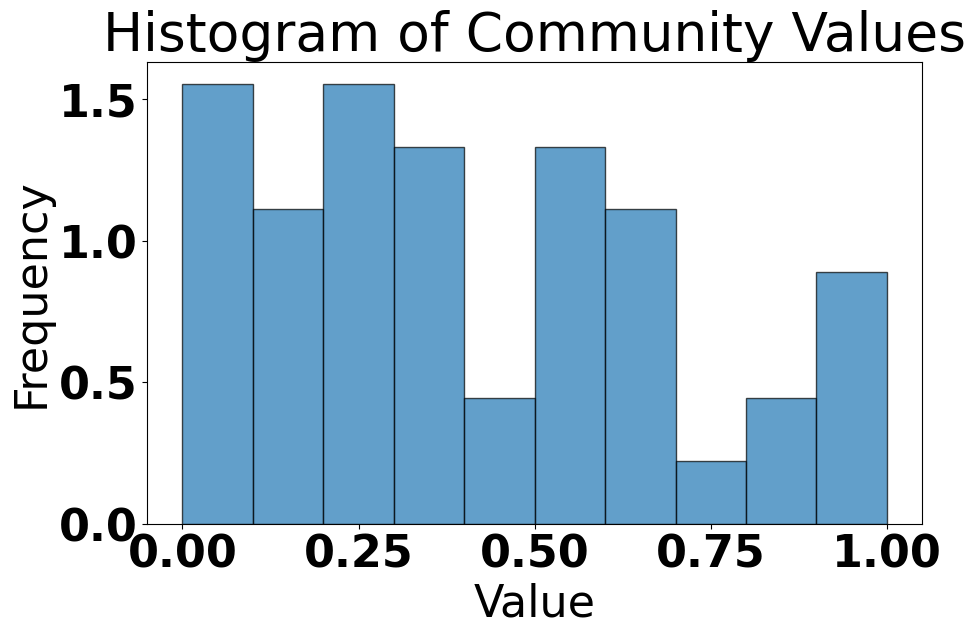

In [120]:
values = list(sorted_community.values())
print(values)
plt.figure(figsize=(10, 6))
plt.hist(values, bins=10, edgecolor='black', alpha=0.7, density=True)
plt.title('Histogram of Community Values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

In [699]:
  #                      other_sides   paddings   all_node_info   self_def_commus 
def tmp_H(starting_node , to_commus , drifters , node_infos , dense_commus , G=G): 

    idx = 0 
    for i in dense_commus : 
        if starting_node in i : 
            break 
        idx += 1 

    for i in to_commus : 
        tmp_pack = [] 
        dd_list = [] 
        tmp_G = G.subgraph(dense_commus[i]) 
        
    
        for ii in drifters : 
            if i in node_infos[ii][2] : 
                tmp_pack.append(ii) 
        tmp_top_btw = top_few_btween_member(tmp_G , "" , 0) 
        print("   starting point" , ":\t" , starting_node) 
        #print("\tdrifters :\t" , tmp_pack) 
        print("essens 0f commu_" + str(i) + " :\t" , tmp_top_btw) 
    
        for ii in dense_commus[idx] : 
            dd_list.append(ii) 
        for ii in dense_commus[i] : 
            dd_list.append(ii) 
        for ii in tmp_pack : 
            dd_list.append(ii) 
        dd_G = G.subgraph(dd_list) 
    
        for i in range(len(tmp_top_btw)) : 
            try : 
                print(">>>LinkingPath " + str(i+1) + " : HEAD --> TAIL\n\t\t" , nx.shortest_path(dd_G , starting_node , tmp_top_btw[i]) ) 
                #break 
            except nx.NetworkXNoPath : 
                print("can't reach" , "[" + tmp_top_btw[i] + "]") 
                if i == len(tmp_top_btw) - 1 : 
                    print("[ NO PATH ]") 
                #print("/////////////////////////////////////////\n////////////// NO PATH /////////////////\n///////////////////////////////////") 
                
            
        #print(">>>LinkingPath : HEAD --> Drifter\n\t\t" , nx.shortest_path(G , "4932.YMR190C" , "4932.YDR545W") ) 
            
        print("\n\n") 



In [700]:
#                      other_sides   paddings   all_node_info   self_def_commus 

next_target_node = "4932.YLR274W" 
other_sides , paddings = possi_dests(next_target_node , self_def_commus , all_node_info) 
tmp_H(next_target_node , other_sides , paddings , all_node_info, self_def_commus , G) 

[4932.YLR274W] @ 27
   starting point :	 4932.YLR274W
essens 0f commu_0 :	 ['4932.YER095W', '4932.YML032C', '4932.YHL022C', '4932.YMR190C', '4932.YFL003C']
>>>LinkingPath 1 : HEAD --> TAIL
		 ['4932.YLR274W', '4932.YKL113C', '4932.YER095W']
>>>LinkingPath 2 : HEAD --> TAIL
		 ['4932.YLR274W', '4932.YKL113C', '4932.YML032C']
>>>LinkingPath 3 : HEAD --> TAIL
		 ['4932.YLR274W', '4932.YNL088W', '4932.YHL022C']
>>>LinkingPath 4 : HEAD --> TAIL
		 ['4932.YLR274W', '4932.YKL113C', '4932.YMR190C']
>>>LinkingPath 5 : HEAD --> TAIL
		 ['4932.YLR274W', '4932.YBR088C', '4932.YER041W', '4932.YFL003C']



   starting point :	 4932.YLR274W
essens 0f commu_15 :	 ['4932.YBR010W', '4932.YBR009C', '4932.YNL031C', '4932.YBR245C', '4932.YHR119W']
>>>LinkingPath 1 : HEAD --> TAIL
		 ['4932.YLR274W', '4932.YBR010W']
>>>LinkingPath 2 : HEAD --> TAIL
		 ['4932.YLR274W', '4932.YBR009C']
>>>LinkingPath 3 : HEAD --> TAIL
		 ['4932.YLR274W', '4932.YNL031C']
>>>LinkingPath 4 : HEAD --> TAIL
		 ['4932.YLR274W', '49

In [701]:
2/0 

ZeroDivisionError: division by zero